# Backprop своими руками

Материалы:

* [Andrew Karpahy: yes, you should understand backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
* [Stanford CS231n](http://cs231n.stanford.edu/)
* [Deep Learning](http://sereja.me/f/deep_learning_goodfellow.pdf) — с 204 страницы и до прозрения
* [Xavier, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

<img width='800px' src='https://cdn-images-1.medium.com/max/1600/1*q1M7LGiDTirwU-4LcFq7_Q.png'>

Иногда сети пишут на чистом C++, причём код для обучения и инференса (реального прогона в продакшне) — отдельно. Так делают, когда нужен очень быстрый отклик и высокая производительность, но это очень трудоемко.

Большинство людей не усложняют себе жизнь и просто используют фреймворки — с ними можно просто почти декларативно описать, какие операции хотите сделать с данными, а он потом сам построит сеть и подгонит её под данные.

Ваше задание — реализовать свой небольшой фреймворк глубокого обучения на чистом `numpy`. Основное время у вас должно уйти на вывод формул для градиентов, анализ поведения самых часто используемых слоев в современных нейросетях и прочий матан. Хотя бы один раз в жизни это надо сделать, а уже потом пользоваться готовыми абстракциями.

Предполагаемый порядок выполнения:
* Поймите на высоком уровне, как работает алгоритм backpropagation
* Изучите пример с логиситической регрессией, чтобы понять, что от вас в итоге хотят
* Изучите код `Module`
* `Sequential`
* `Linear`
* `SoftMax`
* `CrossEntropy`
* Протестируйте их на логситической регрессии
* Напишите код для решения MNIST
* Дописывайте остальные слои, пока не получите на нём 97%

Оценивание (суммарно до 20 баллов):
* 5 баллов -- что-то хоть как-то обучается, MNIST на валидации >90%
* 2 балла -- MNIST на 95%, дальше по одному баллу за 96%, 97% и 98%. Это будет сделать намного сложнее, чем через PyTorch, потому что вам всё нужно писать самим: более сложные оптимизаторы, learning rate decay, думать про численную стабильность и т. д.
* По 2 балла за слои: LeakyReLU, Dropout, BatchNorm, CrossEntropy, SoftMax

Советы:
* Чтобы лучше понять, что должно в итоге получиться, изучите «игрушечный пример» и вообще эту тетрадку, а потом начните читать `hw_framework.py`, где будет более техничное описание.
* Для дебага проверяйте градиенты численно — сдвигайте параметры на какой-нибудь эпсилон и смотрите разницу. Ещё можете проверить, что на одинаковых данных они дают то же, что их эквиваленты из PyTorch (можно после каждого нового слоя добавить юнит тест через `assert`).
* Пишите код без циклов — в питоне они очень долгие; все вычисления можно делать внутри numpy.
* Ограничение на срок сдачи большое — до конца всего курса, но рекомендуется закончить примерно за месяц. Дописывайте его постепенно, разбираясь, как работает каждая функция активации.
* Обсуждайте математику и общую архитектуру фреймворка, но не шарьте друг другу код — так не интересно.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---

Откройте в Jupyter две тетрадки — эту и `hw_framework.ipynb`. В этой содержится train loop, а там непосредственно ваш «фреймворк», который вам ещё предстоит написать.

Архитектура фреймворка вдохновлена PyTorch. Как всегда, если придумаете какой-то более клёвый дизайн — можете использовать его.

In [339]:
%run hw_framework.ipynb

/Users/macbook/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py:2294: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = fn(*args, **kwargs)


CPU times: user 485 ms, sys: 34.3 ms, total: 519 ms
Wall time: 731 ms
CPU times: user 69.9 ms, sys: 6.53 ms, total: 76.4 ms
Wall time: 52.2 ms
[  10.10733793   61.98720613 4077.59114547]


Мы будем использовать самый простой вариант градиентного спуска: просто пройдемся по всем параметрам и сделаем шаги в сторону уменьшения посчитанного заранее градиента.

Есть [более продвинутые методы](http://ruder.io/optimizing-gradient-descent/), но пока что мы их использовать не будем.

In [2]:
def SGD(params, gradients, lr=1e-3):    
    for weights, gradient in zip(params, gradients):
        #print(type(lr), type(gradient))
        #print(lr, gradient)
        weights -= lr * gradient

In [224]:
class Momentum:

    def __init__(self):
        self.v = None   
    
    def optimize(self, params, gradients, lr=1e-3, alpha=0.9):
        if self.v is None:
            self.v = [0] * len(params)  
        for i, (weights, gradient) in enumerate(zip(params, gradients)):
            #print(type(lr), type(gradient))
            #print(lr, gradient)
            self.v[i] = alpha * self.v[i] + gradient
            weights -= self.v[i] * lr

In [243]:
class AdaGrad:

    def __init__(self):
        self.delta = None

    def optimize(self, params, gradients, lr=1e-3, eps=1e-7):
        if self.delta is None:
            self.delta = [0] * len(params)
        for i, (weight, gradient) in enumerate(zip(params, gradients)):
            self.delta[i] += gradient ** 2
            weight -= lr * gradient / (np.sqrt(self.delta[i]) + eps)

In [128]:
class Adam:

    def __init__(self):
        self.m = self.v = None
        self.t = 1

    def optimize(self, params, gradients, lr=1e-3, alpha=0.9, beta=0.99, eps=1e-8):
        if self.m is None:
            self.v = [0] * len(gradients)
            self.m = [0] * len(gradients)
        for i, (weight, gradient) in enumerate(zip(params, gradients)):
            self.m[i] = alpha * self.m[i] + (1 - alpha) * gradient
            self.v[i] = beta * self.v[i] + (1 - beta) * gradient ** 2
            m_corrected = self.m[i] / (1 - alpha ** self.t)
            v_corrected = self.v[i] / (1 - beta ** self.t)
            weight -=  lr * m_corrected / (np.sqrt(v_corrected) + eps)
    

Cоздадим обертку вокруг нашего датасета (просто numpy-евские массивы), которую будем потом использовать, чтобы итерироваться по нему.

In [349]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    # важно, что мы пермешиваем индексы, а не X
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        # в конце нам, возможно, нужно взять неполный батч
        if start + batch_size > n:
            batch_idx = indices[n - batch_size:n]
        else:
            batch_idx = indices[start:start + batch_size]
    
        yield X[batch_idx], Y[batch_idx]

В следующих двух секциях — игрушечные примеры регрессии и классификации на синтезированных данных. В них ничего менять не надо — они нужны, чтобы отдебажить ваши слои в `hw_framework`.

# Линейная регрессия

In [83]:
n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = np.dot(X, true_w).reshape(n, 1)# + np.random.randn()/5

print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w).reshape(n), 2)))

best_possible_mse: 16.641428958496235


### Модель

In [86]:
model = Sequential(
    Linear(10, 1),
)

criterion = MSE()

Можете тут потом тестировать остальные свои слои, когда их напишите.

### Обучение

In [84]:
epochs = 10
batch_size = 10
learning_rate = 1e-1

In [85]:
import matplotlib.pyplot as plt

11.65653500716146
3.11433176374249
1.5002381322433171
0.9417853178266729
2.142370088420425
0.7574086507805047
0.7783384398029434
0.8271868503921794
0.3599628296333252
0.18703744413327109
0.29664178215421005
0.06899664364285987
0.1227624165364802
0.09863742745202317
0.04418224582353472
0.04742523170849789
0.028264231888418607
0.053020991278022865
0.045434884810744855
0.042204924565368805
0.04486215633341198
0.03096187483144646
0.0293197306290656
0.026811804956619396
0.031022236476345926
0.022279907603637468
0.03037455532558147
0.016184722631045298
0.02444877148281606
0.022348203872267967
0.026401050499881402
0.016471788984423943
0.025650022138240636
0.02396372191688644
0.018563820352625746
0.018269946826998396
0.015535803760917486
0.020427479858673832
0.016891486839653268
0.01544873016918041
0.015758471429950707
0.014939267160827139
0.014718525535885898
0.013074305163010263
0.010972227837569242
0.014458610441821656
0.010558013215939072
0.013656743348918069
0.011459840543836832
0.0077577

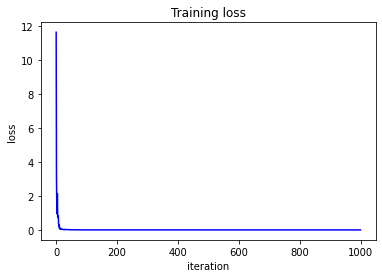

In [87]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        
        #print(y_pred, y_true)
        #print('SUM OF SQUARES:', np.mean(np.power(y_pred-y_true, 2)))
    
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        #print(model.layers[0].W[0][0])
        print(loss)
        
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

# Логистическая регрессия

Этот пример нужнен для теситрования классификации (`CrossEntropy` и `SoftMax`).

Возьмем в качестве датасета точки из двух гауссиан на плоскости.

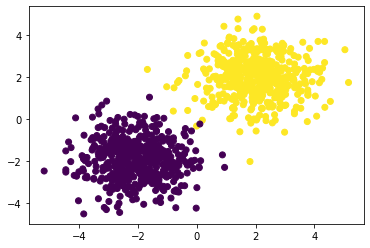

In [124]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)]).astype('int')
#Y = np.vstack([Y, 1-Y])

plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

In [20]:
def permute(nums):
        res = []
        curr = [0] * len(nums)
        def f(i):
            if i == len(nums):
                res.append(curr.copy())
            else:
                for num in nums:
                    print(num)
                    if num not in curr[:i]:
                        print(num, curr[:i])
                        curr[i] = num
                        print(curr)
                        f(i + 1)
                        
        f(0)
        return res
    
print(permute([1, 2]))

1
1 []
[1, 0]
1
2
2 [1]
[1, 2]
2
2 []
[2, 2]
1
1 [2]
[2, 1]
2
[[1, 2], [2, 1]]


Обратите внимание на `y`. Он в формате one-hot: у каждого вектора все нули, кроме одной единицы.

Выходные данные в таком формате упростят написание `CrossEntropy`.

### Модель

Логистическая регрессия — это тоже как бы маленькая нейронка: линейный слой, софтмакс, и максимизируем правдоподобие.

In [125]:
model = Sequential(
    Linear(2, 2),
    SoftMax()
)

criterion = CrossEntropy()

### Обучение

In [343]:
def accuracy(model, val, target, batch_size):
    model.eval()
    total = 0
    correct = 0
    for X, y in loader(val, target, batch_size):
        res = model.forward(X)
        res = np.argmax(res, axis=1)
        y = np.argmax(y, axis=1)
        total += res.shape[0]
        correct += (res == y).sum()
    model.train()
    return correct / total

Мы тут пропустили много важных деталей: валидация, подсчет точности (кроссэнтропия не очень информативна), регуляризация. Вам всё это нужно будет реализовать потом самим.

# Теперь сами

In [131]:
import os
from sklearn.datasets import fetch_openml
# эти библиотеки нужны только для того, чтобы скачать MNISt

if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_openml('mnist_784')
    #mnist = fetch_openml("mnist-original")
    # очень важно его отнормировать -- см. Linear в hw_framework
    X = mnist.data / 255.0
    y = mnist.target
    np.savez('mnist.npz', X=X, y=y)

Переведите лейблы в one-hot.

In [154]:
# ...
y = np.eye(10)[y.astype(np.int64)]

Разделите датасет на train и validation.

In [158]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape

(49000, 784)

Теперь напишите модель и train loop. Можете начать с адаптации предыдущего примера.

Дальше начинается творческая часть и настоящий Deep Learning:
* поиграйтесь с архитектурами;
* поиграйтесь с learning rate и batch_size;
* сделайте learning rate decay;
* сделайте data augmentation.

Have fun. Дедлайн — не две недели, а до конца курса.

In [168]:
model = Sequential(
    Linear(784, 400),
    ReLU(),
    Linear(400, 10),
    Sigmoid()
)

criterion = CrossEntropy()

In [114]:
epochs = 10
batch_size = 64
learning_rate = 1e-2

In [161]:
X_train = X_train.to_numpy().astype(np.float64)
X_val = X_val.to_numpy().astype(np.float64)
y_train = y_train.astype(np.int64)
y_val = y_val.astype(np.int64)

Сначала посмотрим, как наша модель работает со стадратным стохастическим градиентным спуском

0.0946938775510204 0.10080952380952381
0.0963265306122449 0.10233333333333333
0.09693877551020408 0.10323809523809524
0.098 0.1040952380952381
0.09875510204081632 0.10476190476190476
0.10012244897959184 0.10557142857142857
0.101 0.10685714285714286
0.10226530612244898 0.10752380952380952
0.10297959183673469 0.10757142857142857
0.10408163265306122 0.10876190476190477
0.1050204081632653 0.10952380952380952
0.10589795918367347 0.11061904761904762
0.10712244897959183 0.11161904761904762
0.10885714285714286 0.11319047619047619
0.10987755102040817 0.11433333333333333
0.11110204081632653 0.1148095238095238
0.11240816326530612 0.11585714285714285
0.11363265306122448 0.11714285714285715
0.11430612244897959 0.1179047619047619
0.11559183673469388 0.11928571428571429
0.11720408163265306 0.12076190476190476
0.11842857142857142 0.12214285714285714
0.11983673469387755 0.12342857142857143
0.1213265306122449 0.12538095238095237
0.12191836734693877 0.1265238095238095
0.12277551020408163 0.12738095238095

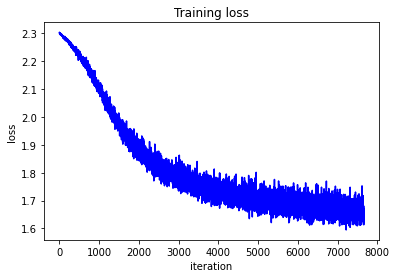

In [122]:
history = []

for i in range(epochs):
    for x, y_true in loader(X_train, y_train, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
    
        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        # логгируем лосс
        #print(loss)
        history.append(loss)
    print(f'Epoch: {i + 1}, train: {accuracy(model, X_train, y_train, batch_size)}, validation: {accuracy(model, X_val, y_val, batch_size)}')


    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [175]:
epochs = 10
batch_size = 64
learning_rate = 1e-2
optimizer = Adam()

Epoch: 1, train: 0.8560204081632653, validation: 0.854904761904762


/var/folders/2w/9zd5xr8x3qg27qldfljyr06r0000gn/T/ipykernel_64301/4260193572.py:7: RuntimeWarning: overflow encountered in exp
  self.output = 1 / (1 + np.exp(-input))


Epoch: 2, train: 0.9200612244897959, validation: 0.9143809523809524
Epoch: 3, train: 0.9248571428571428, validation: 0.9215714285714286
Epoch: 4, train: 0.9118979591836734, validation: 0.9029047619047619
Epoch: 5, train: 0.8914285714285715, validation: 0.891095238095238
Epoch: 6, train: 0.9285102040816327, validation: 0.925
Epoch: 7, train: 0.930734693877551, validation: 0.9267142857142857
Epoch: 8, train: 0.9184081632653062, validation: 0.9144761904761904
Epoch: 9, train: 0.9174897959183673, validation: 0.9157619047619048
Epoch: 10, train: 0.9281428571428572, validation: 0.9233333333333333
Epoch: 11, train: 0.9320612244897959, validation: 0.9287142857142857
Epoch: 12, train: 0.9286734693877551, validation: 0.9228095238095239
Epoch: 13, train: 0.8886122448979592, validation: 0.8869047619047619


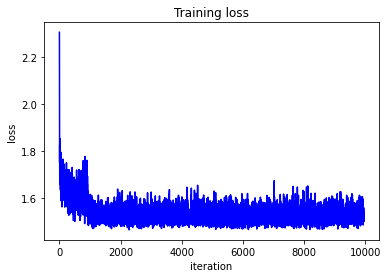

In [149]:
history = []

for i in range(epochs + 3):
    for x, y_true in loader(X_train, y_train, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
    
        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        optimizer.optimize(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        # логгируем лосс
        #print(loss)
        history.append(loss)
    print(f'Epoch: {i + 1}, train: {accuracy(model, X_train, y_train, batch_size)}, validation: {accuracy(model, X_val, y_val, batch_size)}')

plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [226]:
model = Sequential(
    Linear(784, 400),
    ReLU(),
    Linear(400, 10),
    SoftMax()
)

criterion = CrossEntropy()

Посмотрим на работу Momentum

In [234]:
optimizer = Momentum()
epochs = 20

Epoch: 1, train: 0.8841428571428571, validation: 0.8837619047619047
Epoch: 2, train: 0.9065102040816326, validation: 0.9064285714285715
Epoch: 3, train: 0.9167755102040817, validation: 0.9147619047619048
Epoch: 4, train: 0.9238163265306123, validation: 0.9216666666666666
Epoch: 5, train: 0.930265306122449, validation: 0.9271428571428572
Epoch: 6, train: 0.9345102040816327, validation: 0.9319047619047619
Epoch: 7, train: 0.9399795918367347, validation: 0.9356190476190476
Epoch: 8, train: 0.9434489795918367, validation: 0.9383809523809524
Epoch: 9, train: 0.9468163265306122, validation: 0.942047619047619
Epoch: 10, train: 0.9507959183673469, validation: 0.945
Epoch: 11, train: 0.9538163265306122, validation: 0.9484285714285714
Epoch: 12, train: 0.9560204081632653, validation: 0.9501904761904761
Epoch: 13, train: 0.959530612244898, validation: 0.9528095238095238
Epoch: 14, train: 0.9614897959183674, validation: 0.9534761904761905
Epoch: 15, train: 0.9632857142857143, validation: 0.9557142

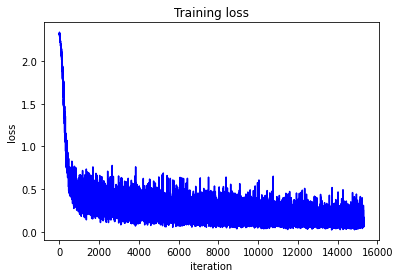

In [227]:
history = []
best_acc = 0

for i in range(epochs):
    for x, y_true in loader(X_train, y_train, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
    
        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        optimizer.optimize(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        # логгируем лосс
        #print(loss)
        history.append(loss)
    val_acc = accuracy(model, X_val, y_val, batch_size)
    print(f'Epoch: {i + 1}, train: {accuracy(model, X_train, y_train, batch_size)}, validation: {val_acc}')
    if val_acc > best_acc:
        best_acc = val_acc


print(f'Best accuracy: {best_acc}')   
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [377]:
model = Sequential(
    Linear(784, 400),
    Dropout(),
    ReLU(),
    Linear(400, 10),
    SoftMax()
)

Посмотрим на работу AdaGrad

In [347]:
epochs = 50
optimizer = AdaGrad()

Epoch: 1, train: 0.9758571428571429, validation: 0.9670952380952381
Epoch: 2, train: 0.977938775510204, validation: 0.9692380952380952
Epoch: 3, train: 0.9794897959183674, validation: 0.9705238095238096
Epoch: 4, train: 0.9804693877551021, validation: 0.9711904761904762
Epoch: 5, train: 0.9813877551020408, validation: 0.9719047619047619
Epoch: 6, train: 0.9821632653061224, validation: 0.9727142857142858
Epoch: 7, train: 0.9828367346938776, validation: 0.9723333333333334
Epoch: 8, train: 0.9833673469387755, validation: 0.9726666666666667
Epoch: 9, train: 0.9837755102040816, validation: 0.9731904761904762
Epoch: 10, train: 0.984204081632653, validation: 0.9731428571428572
Epoch: 11, train: 0.9845102040816327, validation: 0.9735714285714285
Epoch: 12, train: 0.9849183673469388, validation: 0.9734285714285714
Epoch: 13, train: 0.9851632653061224, validation: 0.9735238095238096
Epoch: 14, train: 0.9854081632653061, validation: 0.9739047619047619
Epoch: 15, train: 0.9856938775510204, validat

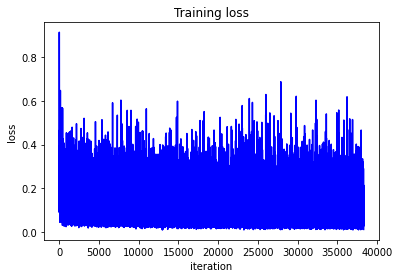

In [348]:
history = []
best_acc = 0

for i in range(epochs):
    for x, y_true in loader(X_train, y_train, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
    
        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        optimizer.optimize(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        # логгируем лосс
        #print(loss)
        history.append(loss)
    val_acc = accuracy(model, X_val, y_val, batch_size)
    print(f'Epoch: {i + 1}, train: {accuracy(model, X_train, y_train, batch_size)}, validation: {val_acc}')
    if val_acc > best_acc:
        best_acc = val_acc

print(f'Best accuracy: {best_acc}')   
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [394]:
model = Sequential(
        Linear(784, 400),
        Dropout(),
        ReLU(),
        Linear(400, 10),
        SoftMax()
    )

In [395]:
epochs = 100
optimizer = Momentum()
batch_size = 16
learning_rate = 0.09

Epoch: 1, train: 0.9526199804113614, validation: 0.950019040365575
Epoch: 2, train: 0.9651077375122429, validation: 0.9577779893373953
Epoch: 3, train: 0.9689642507345739, validation: 0.9586824067022087
Epoch: 4, train: 0.974922461638916, validation: 0.965917745620716
Epoch: 5, train: 0.9773506366307542, validation: 0.9669649657273419
Epoch: 6, train: 0.9802889324191969, validation: 0.970963442498096
Epoch: 7, train: 0.9817172706496898, validation: 0.9711538461538461
Epoch: 8, train: 0.9842474698008489, validation: 0.9722962680883473
Epoch: 9, train: 0.9845331374469475, validation: 0.9732958872810358
Epoch: 10, train: 0.9858798563499837, validation: 0.9732482863670983
Epoch: 11, train: 0.986900097943193, validation: 0.9751523229246002
Epoch: 12, train: 0.9861247143323539, validation: 0.9747715156130998
Epoch: 13, train: 0.9871449559255632, validation: 0.9743431073876618
Epoch: 14, train: 0.9875122428991185, validation: 0.9756283320639756
Epoch: 15, train: 0.9888385569702905, validation

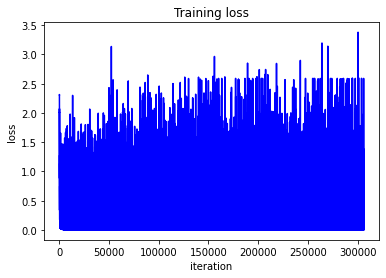

In [396]:
history = []
best_acc = 0

for i in range(epochs):
    for x, y_true in loader(X_train, y_train, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
    
        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        optimizer.optimize(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        # логгируем лосс
        #print(loss)
        history.append(loss)
    val_acc = accuracy(model, X_val, y_val, batch_size)
    print(f'Epoch: {i + 1}, train: {accuracy(model, X_train, y_train, batch_size)}, validation: {val_acc}')
    if val_acc > best_acc:
        best_acc = val_acc

print(f'Best accuracy: {best_acc}')   
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()